# Count me

In [1]:
# imports
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson

from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy import units

In [2]:
def set_fontsize(ax, fsz):
    """
    Set the fontsize throughout an Axis

    Args:
        ax (Matplotlib Axis):
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)


# Load data

In [3]:
data = Table.read('../Data/master_table_redcam.fits')

In [4]:
data[0:5]

frame,UTC,flux_1FWHM,fluxerr_1FWHM,flux_2FWHM,fluxerr_2FWHM,flux_star1_1FWHM,flux_star1_2FWHM,x_star1,y_star1,SN_star1,flux_star2_1FWHM,flux_star2_2FWHM,x_star2,y_star2,SN_star2,flux_star3_1FWHM,flux_star3_2FWHM,x_star3,y_star3,SN_star3,MJD,file
int64,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes29
1,07:42:37.5,41.09619966387744,204.3105572221791,708.1392292153837,410.30599587347393,161.15999999999994,733.4000000000004,67.4775429326288,208.52146631439894,27.081358902388935,867.96,1154.96,77.45429740791269,247.66507503410642,33.98470244095128,699.7200000000001,911.920000000001,219.01283585336668,241.54313064288044,30.19801317967791,59145.320596604084,count_table_reduced_01_r.fits
2,07:42:37.5,1319.3480070877076,303.7042626786741,7842.342931165101,611.0096404430687,126832.08,171249.24000000002,70.72577147578328,201.1659431072298,413.8227156645706,17255.280000000002,26214.279999999995,79.11964937144057,240.93737442662723,161.90824562078362,53108.119999999995,71879.63999999997,219.48939617146652,242.7834837014834,268.1037858740528,59145.32059673827,count_table_reduced_01_r.fits
3,07:42:37.5,1931.2358083868028,300.70813484360747,10838.24466142595,605.4659129476277,133895.48,179014.07999999996,70.8221427896834,201.17037593311719,423.10055542388494,14986.520000000004,25638.399999999998,79.07610279962599,241.3169001980089,160.11995503371838,43805.08,64405.24000000001,219.9698534068555,242.0887384018314,253.78187484530886,59145.32059687244,count_table_reduced_01_r.fits
4,07:42:37.5,1748.7043463277814,298.45045507817014,7231.171118897203,598.5630554163253,127669.60000000002,173886.63999999998,71.11263135383966,201.21414842962898,416.99717025418767,18244.360000000004,29723.960000000003,78.16490023557878,240.55132076585238,172.4063803923741,45356.76000000001,62081.56000000001,219.38856152387743,242.3897359425101,249.1617145550255,59145.32059700662,count_table_reduced_01_r.fits
5,07:42:37.5,2266.8467990481854,299.00791510123736,9563.821881459062,599.8886049234525,122921.68,168733.08000000007,71.02556898451927,200.9617680031375,410.77132324445444,17142.360000000004,27718.240000000023,79.2684134369226,241.70508670777588,166.48795752245871,48848.44000000001,68021.36,219.90539603876448,242.32537963253435,260.80904892277033,59145.320597140795,count_table_reduced_01_r.fits


In [66]:
ndata = len(data)
ndata

100000

# Diagnostics

In [24]:
gd_frame = data['frame'] > 1

In [25]:
C_gal = data['flux_2FWHM'].data[gd_frame]

## Time

In [8]:
dt = data['MJD'][1] - data['MJD'][0]
dt * 24 * 60 * 60

0.011593429371714592

In [12]:
t0 = Time(data['MJD'][0], format='mjd')
t0.isot

'2020-10-23T07:41:39.547'

## Time evolution

In [32]:
x = (data['MJD'][gd_frame]-59145)*24*60*60
y = C_gal*5.6/2000
p, V = np.polyfit(x, y, 1, cov=True)
p

array([-6.84400548e-04,  4.35452300e+01])

In [33]:
f = np.poly1d(p)

In [34]:
f(xval[0]), f(xval[-1])

(43.32581343143557, 43.315896421440115)

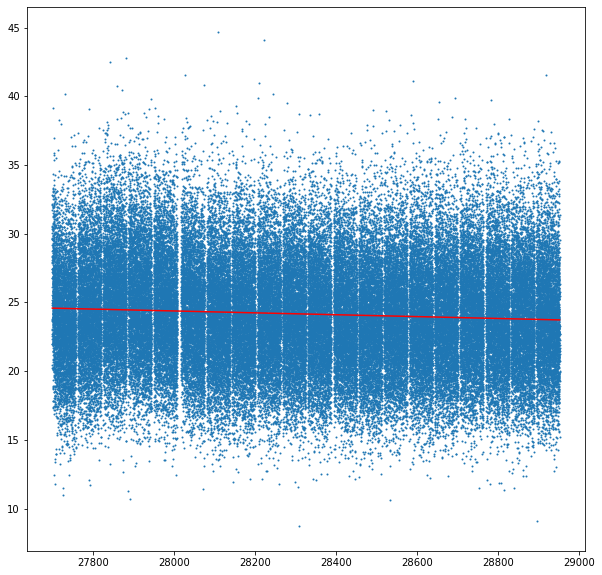

In [35]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.scatter(x, y, s=1)
# Fit
xval = np.linspace(x.min(), x.max(), 10000)
ax.plot(xval, f(xval), 'r-')
plt.show()

# Gaussian Galaxy

## Fit

In [17]:
mean_gal, std_gal = norm.fit(C_gal)

## Plot

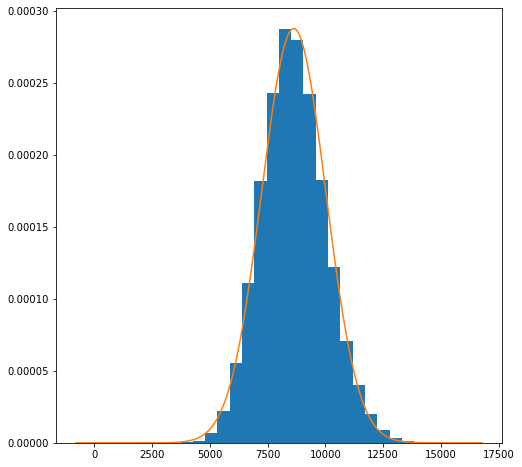

In [51]:
fig = plt.figure(figsize=(8,8))
plt.hist(C_gal, bins=30, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean_gal, std_gal)
plt.plot(x, y)
plt.show()

## Examine the tails

In [19]:
isort_gal = np.argsort(C_gal)

In [15]:
cdf = (np.arange(isort_gal.size)+1) / isort_gal.size

### High end

In [36]:
norm.cdf(15000., loc=mean_gal, scale=std_gal)

0.9999978242613436

In [37]:
xval = np.linspace(mean_gal, C_gal.max(), 100000)

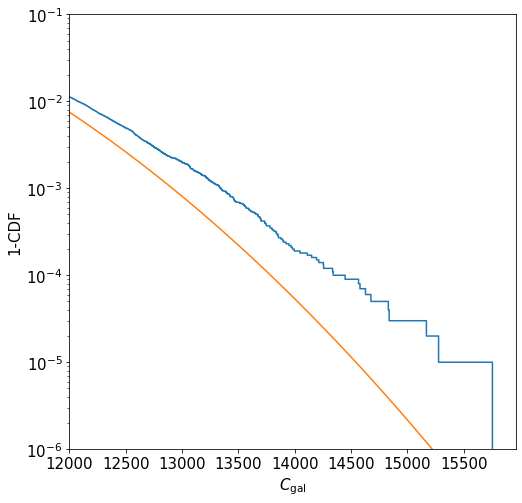

In [40]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
# Data
ax.step(C_gal[isort_gal], 1.-cdf)
ax.plot(xval, 1-norm.cdf(xval, loc=mean_gal, scale=std_gal))
#
ax.set_xlim(12000., np.max(C_gal))
ax.set_ylim(1e-6, 1e-1)
#
ax.set_yscale('log')
ax.set_xlabel(r'$C_{\rm gal}$')
ax.set_ylabel('1-CDF')
set_fontsize(ax, 15.)
#
#
plt.show()

### Low tail

In [47]:
mean_gal

8626.391053122208

In [45]:
xval2 = np.linspace(C_gal.min(), mean_gal, 100000)

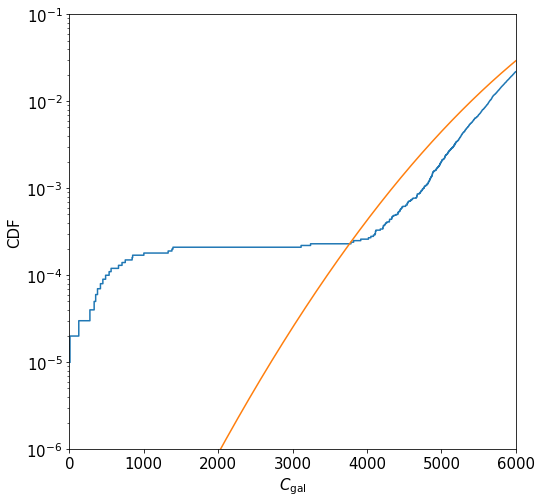

In [50]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
# Data
ax.step(C_gal[isort_gal], cdf)
ax.plot(xval2, norm.cdf(xval2, loc=mean_gal, scale=std_gal))
#
ax.set_xlim(0., 6000.)
ax.set_ylim(1e-6, 1e-1)
#
ax.set_yscale('log')
ax.set_xlabel(r'$C_{\rm gal}$')
ax.set_ylabel('CDF')
set_fontsize(ax, 15.)
#
#
plt.show()

# FRB

In [55]:
# Fake
FRB_time = Time('2020-10-23T07:48:30.777667') - 9.1*units.s
FRB_time.mjd

59145.325250898924

## Alopeke error

In [56]:
ata = 163*units.s/1000.

In [58]:
mjd_low = (FRB_time-ata/2.).mjd
mjd_high = (FRB_time+ata/2.).mjd

In [59]:
i_FRB = (data['MJD']>=mjd_low) & (data['MJD']<=mjd_high)
np.sum(i_FRB)

14

In [60]:
# Also made up
C_obs_FRB = C_gal[i_FRB]

## Compare to Gaussian

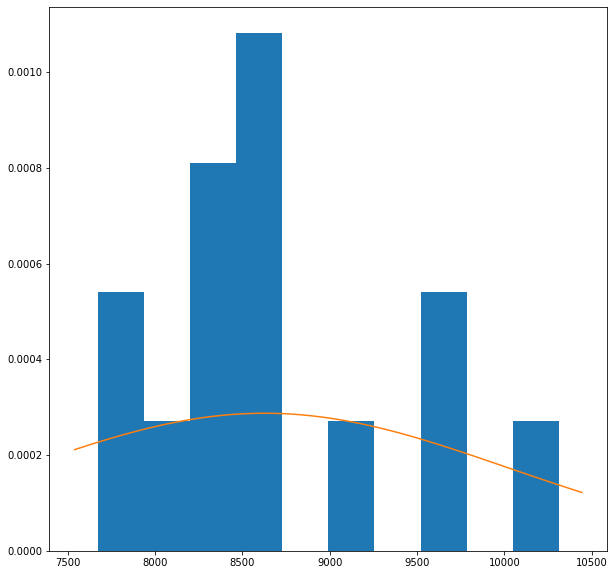

In [61]:
fig = plt.figure(figsize=(10,10))
plt.hist(C_obs_FRB, bins=10, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean_gal, std_gal)
plt.plot(x, y)
plt.show()

In [63]:
maxC_obs_FRB = np.max(C_obs_FRB)
maxC_obs_FRB

10311.480634150505

# Monte Carlo me

In [64]:
C_FRB = 5000.

In [71]:
rand_C_FRB = poisson.rvs(C_FRB, size=(ndata, 1000))

## Add em

In [72]:
rand_C_obs = np.outer(C_gal, np.ones(1000)) + rand_C_FRB

In [73]:
rand_C_obs.shape

(100000, 1000)

In [74]:
np.sum(rand_C_obs > maxC_obs_FRB) / rand_C_obs.size

0.99542852